(100000, 4)
   user  item  rating  timestamp
0   196   242       3  881250949
1   186   302       3  891717742
2    22   377       1  878887116
3   244    51       2  880606923
4   166   346       1  886397596
Usuarios únicos: 943
Items únicos: 1682


<Axes: >

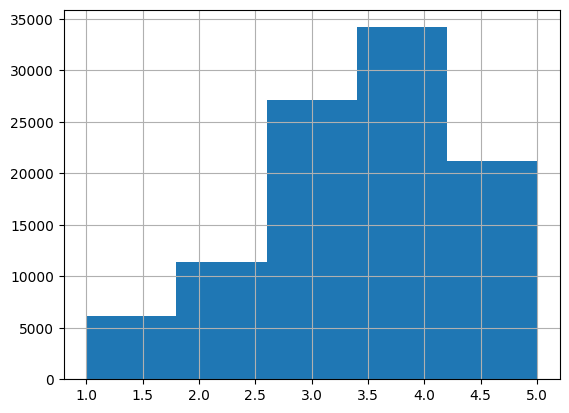

In [5]:
import pandas as pd

# Cargar datos
ratings = pd.read_csv("../data/ml-100k/u.data", sep="\t", names=["user", "item", "rating", "timestamp"])

print(ratings.shape)
print(ratings.head())

# Usuarios y items únicos
print("Usuarios únicos:", ratings["user"].nunique())
print("Items únicos:", ratings["item"].nunique())

# Histograma de ratings
ratings["rating"].hist(bins=5)


In [6]:
import pandas as pd

# 1) Cargar y ordenar por usuario y tiempo
ratings = pd.read_csv("../data/ml-100k/u.data", sep="\t",
                      names=["user","item","rating","timestamp"])
ratings = ratings.sort_values(["user","timestamp"])

# 2) Para cada usuario, la última interacción = TEST; el resto = TRAIN
test_idx = ratings.groupby("user").tail(1).index
test = ratings.loc[test_idx].copy()
train = ratings.drop(test_idx).copy()

# 3) Guardar por si usas otros notebooks
train.to_csv("../data/train.csv", index=False)
test.to_csv("../data/test.csv", index=False)

len(train), len(test), train.user.nunique(), test.user.nunique()


(99057, 943, 943, 943)

In [7]:
import numpy as np

# 1) Ranking global de popularidad (relevante = rating >= 4)
pop_series = (train[train["rating"] >= 4]
              .groupby("item").size()
              .sort_values(ascending=False))

# Si algún ítem no tiene votos >=4, asegúrate de incluirlos al final con 0
all_items = pd.Index(train["item"].unique())
pop_series = pop_series.reindex(all_items, fill_value=0)

pop_ranking = pop_series.index.values  # array de item_ids ordenados por popularidad

# 2) Items vistos por usuario en TRAIN (para no recomendar repetidos)
seen_by_user = train.groupby("user")["item"].apply(set).to_dict()

def recommend_pop(user_id, K=10):
    seen = seen_by_user.get(user_id, set())
    recs = [i for i in pop_ranking if i not in seen]
    return recs[:K]



In [12]:
import numpy as np
import math

# (opcional) Asegura tipos int por si acaso
test[["user","item"]] = test[["user","item"]].astype(int)

def evaluate_loo_topk(recommender_fn, test_df, K=10):
    hits, ndcgs = [], []
    for _, row in test_df.iterrows():
        u = int(row["user"])
        true_item = int(row["item"])
        recs = recommender_fn(u, K=K)
        if true_item in recs:
            pos = recs.index(true_item)  # 0-based
            hits.append(1)
            ndcgs.append(1.0 / math.log2(pos + 2))  # NDCG para 1 relevante
        else:
            hits.append(0)
            ndcgs.append(0.0)
    return float(np.mean(hits)), float(np.mean(ndcgs))

hit10, ndcg10 = evaluate_loo_topk(recommend_pop, test, K=10)
hit20, ndcg20 = evaluate_loo_topk(recommend_pop, test, K=20)
print(f"Popularity HitRate@10: {hit10:.4f} | NDCG@10: {ndcg10:.4f}")
print(f"Popularity HitRate@20: {hit20:.4f} | NDCG@20: {ndcg20:.4f}")


Popularity HitRate@10: 0.0350 | NDCG@10: 0.0138
Popularity HitRate@20: 0.0615 | NDCG@20: 0.0205


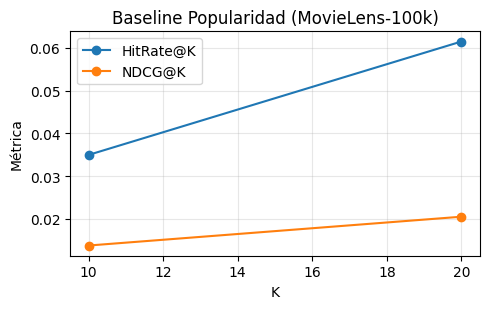

In [14]:
import matplotlib.pyplot as plt

ks = [10, 20]
hits = [hit10, hit20]
ndcgs = [ndcg10, ndcg20]

plt.figure(figsize=(5,3.2))
plt.plot(ks, hits, marker="o", label="HitRate@K")
plt.plot(ks, ndcgs, marker="o", label="NDCG@K")
plt.title("Baseline Popularidad (MovieLens-100k)")
plt.xlabel("K")
plt.ylabel("Métrica")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/popularity_metrics.png", dpi=160)
plt.show()



In [15]:
# media global
mu = train["rating"].mean()

# por item: n_i (cuántos ratings) y rbar_i (media)
grp = train.groupby("item")["rating"]
n_i = grp.size()
rbar_i = grp.mean()

m = 20  # suavizado; sube/baja según tamaño del dataset
bayes_score = (n_i*rbar_i + m*mu) / (n_i + m)
bayes_score = bayes_score.reindex(all_items, fill_value=mu)

bayes_ranking = bayes_score.sort_values(ascending=False).index.values

def recommend_pop_bayes(user_id, K=10):
    seen = seen_by_user.get(user_id, set())
    recs = [i for i in bayes_ranking if i not in seen]
    return recs[:K]

hit10_b, ndcg10_b = evaluate_loo_topk(recommend_pop_bayes, test, K=10)
print(f"Popularity (Bayes) HitRate@10: {hit10_b:.4f} | NDCG@10: {ndcg10_b:.4f}")



Popularity (Bayes) HitRate@10: 0.0329 | NDCG@10: 0.0140


In [16]:
import pandas as pd
pd.DataFrame([
    {"model":"Popularity","K":10,"HitRate":hit10,"NDCG":ndcg10},
    {"model":"Popularity","K":20,"HitRate":hit20,"NDCG":ndcg20},
    {"model":"Popularity (Bayes)","K":10,"HitRate":hit10_b,"NDCG":ndcg10_b},
]).to_csv("../reports/metrics_popularity.csv", index=False)
